# Tutorial of using AIF 360 to predict default of credit cards with adjusted bias on sex

Author: Yi Wang

GitHub: https://github.com/yahowang

Data source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Idea Inspiration: https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb

Public Paper: Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

License: MIT License

## Intro
Because of the advance of financial crediting system, customers are able to make an expense with their creditability and pay off in the future. Yet, it is challenging yet vital for banks to determine whether their customers would have the ability to pay off their credits to minimize the risk of capital loss. Therefore, one of the ways of doing so is to track historical transactions and payments to target potential customers who will not meet payoff requirements. These customers will be classified and will have a greater change of fedault in the future. 

In this task, the dataset was obtained from banks in Taiwan and was meant to target the case of customers default payments. This is a binary classification problem and the target valuable is  whether acustomer will default or not based on different features and payment histories. 

This dataset contains more females than males and the males have more instances being credit card default. With the use of AI Fairness 360 (AIF 360), we can adjust the bias on sex and compare the performance of a simple model on the original and transformed dataset.

## Feature Description
Since UCI Machine Learning Repository has some wrong information about feature decriptions, I will list the features in detail as below.

$X_1$: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

$X_2$: Sex (1 = male; 2 = female).

$X_3$: Education (1 = graduate school; 2 = university; 3 = high school; 0,4,5,6 = others).

$X_4$: Marriage (1 = married; 2 = single; 3 = divorce; 0 = others).

$X_5$: Age (year).

$X_6$ - $X_{11}$: History of past payment (with 10 categories for each feature).
- The measurement scale for the repayment status is: 
  - -2 = No consumption
  - -1 = payment in full
  - 0 = minimum amount of payment
  - 1 = payment delay for one month
  - 2 = payment delay for two months
  - 3 = payment delay for three months
  - 4 = payment delay for four months
  - 5 = payment delay for five months
  - 6 = payment delay for six months
  - 7 = payment delay for seven months
  - 8 = payment delay for eight months
  - 9 = payment delay for nine months and above
- $X_6$ = the repayment status in September, 2005 
- $X_7$ = the repayment status in August, 2005
- $X_8$ = the repayment status in July, 2005
- $X_9$ = the repayment status in June, 2005
- $X_{10}$ = the repayment status in May, 2005
- $X_{11}$ = the repayment status in April, 2005

$X_{12}$-$X_{17}$: Amount of bill statement (NT dollar)
- $X_{12}$ = amount of bill statement in September, 2005
- $X_{13}$ = amount of bill statement in August, 2005
- $X_{14}$ = amount of bill statement in July, 2005
- $X_{15}$ = amount of bill statement in June, 2005
- $X_{16}$ = amount of bill statement in May, 2005
- $X_{17}$ = amount of bill statement in April, 2005

$X_{18}$-$X_{23}$: Amount of previous payment (NT dollar).
- $X_{18}$ = amount paid in September, 2005
- $X_{19}$ = amount paid in August, 2005
- $X_{20}$ = amount paid in July, 2005
- $X_{21}$ = amount paid in June, 2005
- $X_{22}$ = amount paid in May, 2005
- $X_{23}$ = amount paid in April, 2005.

$X_{24}$: Whether the customer will default in the next session (1 = Yes; 0 = No)

## Loading Raw Data and Preprocessing

First we need to load the data and wrap it in a standard AIF360 dataset such that many metrics can be used later.

In [16]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import matplotlib
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from IPython.display import Markdown, display
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc

The customeized preprocessing function for this dataset

In [2]:
def preprocess(df):
    """
    Customized preprocessing method for the dataset.
    Input: original df
    Output: preprocessed df
    """
    # Standard Scaler
    scaler = StandardScaler()
    continuous =['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
    df[continuous] = scaler.fit_transform(df[continuous])

    # Payment status contains a mixture of qualitative and quantitative values
    # Thus, it needs a special preprocessing to decouple the mixture
    mixed_features = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
    for mixed_feature in mixed_features:
        for i in range(-2,1):
            df[mixed_feature + "_" + str(i)] = [1 if t else 0 for t in df[mixed_feature] == i]
            df[mixed_feature] = [0 if t == i else t for t in df[mixed_feature]]

    # One Hot
    ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
    features = ["EDUCATION", "MARRIAGE"]
    temp = ohe.fit_transform(df[features])

    for i in range(len(ohe.get_feature_names())):
        feature_name = ohe.get_feature_names()[i].split("_")
        feature_name = features[int(feature_name[0][1])] + "_" + feature_name[1]    
        temp_i = pd.DataFrame(temp[:, i], columns = [feature_name])
        df = pd.concat([df, temp_i], axis = 1)

    for feature in features:
        df = df.drop(feature, axis = 1)

    # Minmax
    continuous =  ["AGE"]  + mixed_features
    minmax = MinMaxScaler()
    df[continuous] = minmax.fit_transform(df[continuous])

    return df

#### Dataset Wrapper

Here we convert the raw data to a standard dataset. We need to protect the feature that has bias. Here we should pretect 'SEX' in our data. We also need to specify the privileged group and unprivileged group in the feature. Here, the privileged group is male and unprivileged group is the female.

In [3]:
file_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(file_path, skiprows = 1)
df['SEX'] = df['SEX']-1 # make male to 0 and female to 1

privileged_groups = [{'SEX': 0}] # male
unprivileged_groups = [{'SEX': 1}] # female
label_name = "default payment next month"
favorable_classes = [1] # 1 means default of credit being true
protected_attribute_names = ['SEX']
privileged_classes = [[0]] # male

metadata={'label_maps': [{1: 'Default', 0: 'Not Default'}]}

orig_data = StandardDataset(df, 
                            label_name, 
                            favorable_classes, 
                            protected_attribute_names, 
                            privileged_classes,
                            custom_preprocessing=preprocess)

np.random.seed(2080)
dataset_orig_train, dataset_orig_vt = orig_data.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

## Metric for the original dataset

Now that we have identified the protected attribute 'SEX' and defined privileged and unprivileged values, we can use aif360 to detect bias in the dataset. One simple test is to compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter. A negative value indicates that females are less likely having credit card default in the future. This is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class. The code below performs this check and displays the output, showing that the difference is -0.034253.

In [58]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.034253


## Transform the training data

We do see some bias between females and males. Now we need to adjust for this bias in our training. Reweighing is a preprocessing technique that reweighs each (group, label) combination differently to ensure fairness before classificatio

In [4]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

Check the mean difference between two groups again with the mean difference.

In [5]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


## Model comparison with fittings on different datasets

We would like to see if the preprocssing of data would hurt the performance of the model. So we trained a simple Random Forest classifier on both original and transformed training data, then compare the Area Under ROC, namely AUC, on testing data.

### Fit a Random Forest classifier with the original data

In [17]:
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
X_valid = dataset_orig_valid.features
y_valid = dataset_orig_valid.labels.ravel()
X_test = dataset_orig_test.features
y_test = dataset_orig_test.labels.ravel()

random_state = 2080
max_depth = range(1,10) # max depths that the model can split further
minimum_splits = range(2,10) # minimum splits that the model can split further
accuracies = [] # validation accuracies
models = []

# finding the best metrics
for d in max_depth:
    for s in minimum_splits:
        rfc = RandomForestClassifier(n_estimators=50, min_samples_split=s, max_depth=d, random_state=random_state)
        rfc.fit(X_train,y_train, sample_weight=dataset_orig_train.instance_weights)
        accuracies.append(accuracy_score(y_valid, rfc.predict(X_valid)))
        models.append(rfc)

# find the best model based on the validation accuracies
model = models[np.argmax(accuracies)]

# calculate the false positive rate and true positive rate of our best model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

#### Visualize the ROC for model fitted on the original data

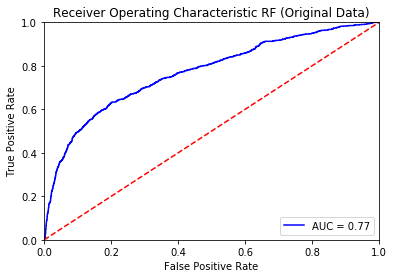

In [18]:
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
plt.title('Receiver Operating Characteristic RF (Original Data)')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Fit a Random Forest classifier with the transformed data

In [19]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

random_state = 2080
max_depth = range(1,10)
minimum_splits = range(2,10)
accuracies = []
models = []

# finding the best metrics
for d in max_depth:
    for s in minimum_splits:
        rfc = RandomForestClassifier(n_estimators=50, min_samples_split=s, max_depth=d, random_state=random_state)
        rfc.fit(X_train,y_train, sample_weight=dataset_transf_train.instance_weights)
        accuracies.append(accuracy_score(y_valid, rfc.predict(X_valid)))
        models.append(rfc)

# find the best model according to the accuracy score
model = models[np.argmax(accuracies)]

# calculate the false positive rate and true positive rate of our best model
fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(X_test)[:,1])

#### Visualize the ROC for model fitted on the transformed data

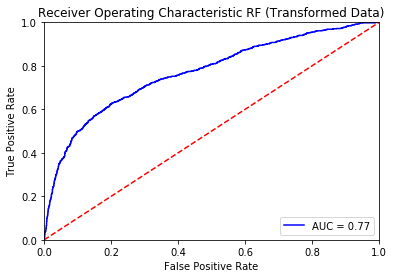

In [20]:
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
plt.title('Receiver Operating Characteristic RF (Transformed Data)')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

We do see that mitigating the gender effect on the model can reduce the mean difference between males and female in terms of their proportion of being default. The model fitted on the transformed data can also perform more fairly than the original dataset in terms of ethics. The ROC curves are a bit different but the AUC is not impacted largely, which is a good thing we would like to observe. This means that the model fitted on unbiased 'SEX' groups can evaluate people more fairly without paying too much attention on their sex.